In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# from ipywidgets import interact, IntSlider, FloatSlider, fixed
# from astropy.modeling.models import Gaussian1D

import lightkurve as lk

# import seaborn as sns

# import echelle
from astropy.timeseries import LombScargle
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

# from astropy.timeseries import LombScargle
# from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
# from astropy.convolution import convolve_fft
from astropy.stats import sigma_clip

/Users/ccra8514/anaconda3/envs/notebook_lk/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/ccra8514/.lightkurve/cache. Please move all the files in the legacy directory /Users/ccra8514/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 17
plt.rcParams['axes.labelsize'] = 15
# plt.rcParams['savefig.transparent'] = False
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.edgecolor'] = 'white'

In [4]:
def calc_lomb_scargle(t,y):
   oversample = 10
   tmax = t[-1]#t.max()
   tmin = t[0]#t.min()
   df = 1.0 / (tmax - tmin)
   fmin = df
   fmax = 40 #25 #600 # maximum frequency in cycles per day (c/d)
 
   freq = np.arange(fmin, fmax, df / oversample)
   model = LombScargle(t, y)
   sc = model.power(freq, method="fast", normalization="psd")
 
   fct = np.sqrt(4./len(t))
   amp = np.sqrt(sc) * fct
   return freq*11.574, amp*1E6 # return frequency in muHz and amplitude in ppm

In [5]:
def apply_highpassfilter(time, flux, width_days, sigma_clip_flag=True, sigma=4):
    cadence = np.median(np.diff(time))
    filter_width = width_days/cadence
#     print(filter_width)
    highlysmoothed_flux = convolve(flux, Gaussian1DKernel(filter_width),boundary='extend')
    hpfiltered_flux = flux/highlysmoothed_flux
    
    if sigma_clip_flag==True:
        clipped_flux = sigma_clip(hpfiltered_flux, sigma=sigma, maxiters=1)
        time = time[~clipped_flux.mask]
        hpfiltered_flux = clipped_flux.data[~clipped_flux.mask]
    
    return time, hpfiltered_flux

In [6]:
# width_days = 11.574/(4) # 5 # 1
# #     width_days = 1#.5
# time = np.asarray(lc_echelle_sap.time.value)
# flux = np.asarray(lc_echelle_sap.flux.value)
# time, hpfiltered_flux = apply_highpassfilter(time,flux,
#                                              width_days=width_days)
# clipped_flux = sigma_clip(hpfiltered_flux, sigma=4, maxiters=1)
# # if sigma_flag == True:
# time = time[~clipped_flux.mask]
# hpfiltered_flux = clipped_flux.data[~clipped_flux.mask]

# hpfiltered_flux = (hpfiltered_flux-1)#*1e6 # convert from percent to ppm

# Pulling the TPF

In [7]:
lc = lk.search_lightcurve('HD 205577')
lc

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,QLP,1800,441027157,0.0
1,TESS Sector 01,2018,GSFC-ELEANOR-LITE,1800,441027157,0.0
2,TESS Sector 01,2018,TASOC,1800,441027157,0.0
3,TESS Sector 01,2018,TASOC,1800,441027157,0.0
4,TESS Sector 01,2018,TGLC,1800,441027157,0.0
5,TESS Sector 28,2020,QLP,600,441027157,0.0


In [8]:
QLP = lc[0].download()

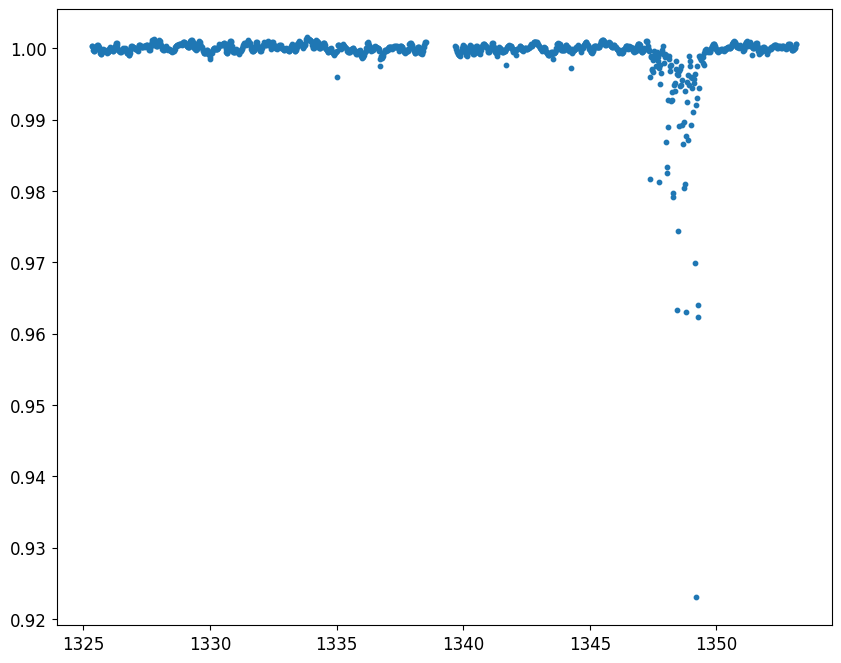

In [9]:
# QLP.plot();
plt.scatter(QLP.time.value,QLP.flux.value,s=10)
plt.show()

In [10]:
## need to either sigma clip or mask out that entire section, the entire thing is screwed up there

In [11]:
QLP_clipped = QLP.remove_nans().remove_outliers(sigma=5)

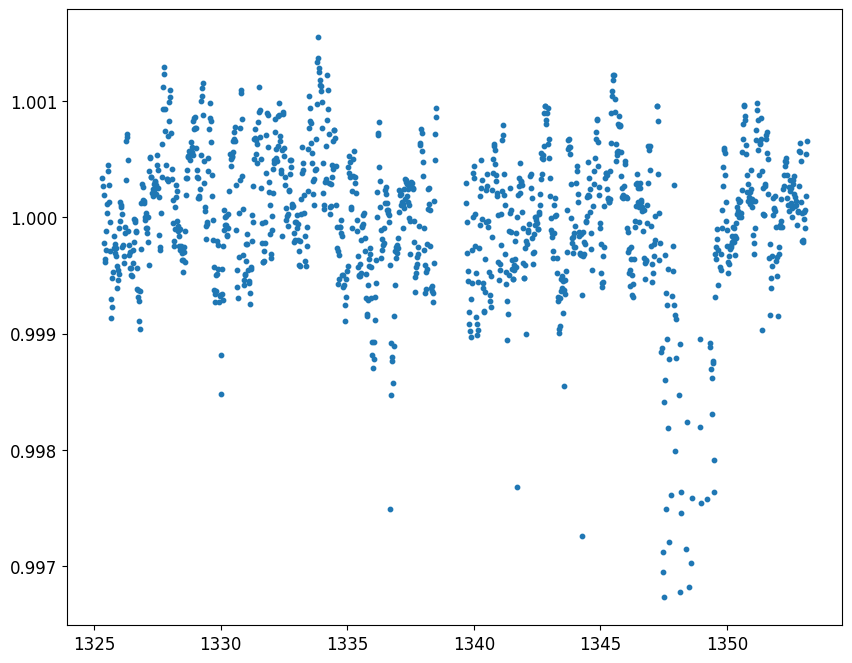

In [12]:
# QLP_clipped.plot();
plt.scatter(QLP_clipped.time.value,QLP_clipped.flux.value,s=10)
plt.show()

In [13]:
tesscut = lk.search_tesscut('HD 205577')
tesscut

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,TESScut,1426,HD 205577,0.0
1,TESS Sector 28,2020,TESScut,475,HD 205577,0.0


# Sector 1

In [14]:
tpf = tesscut[0].download(cutout_size=10)

In [15]:
target_mask = tpf.create_threshold_mask(threshold=5, reference_pixel='center')
n_target_pixels = target_mask.sum()
n_target_pixels

21

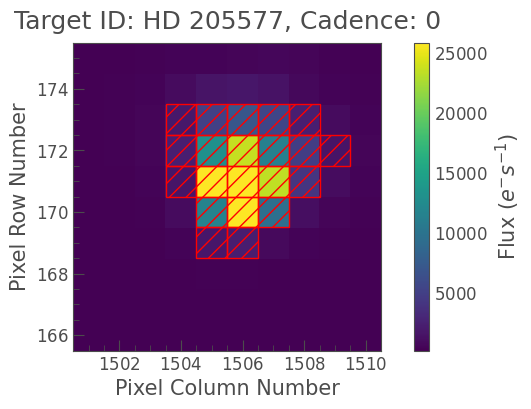

In [16]:
tpf.plot(aperture_mask=target_mask);

In [17]:
# tpf.interact_sky(aperture_mask=target_mask)

In [18]:
target_lc = tpf.to_lightcurve(aperture_mask=target_mask)


In [19]:
bad_mask = []
for i in range(0,len(target_lc)):
    if i >= 990 and i <= 1090: 
        bad_mask.append(False)
    else:
        bad_mask.append(True)

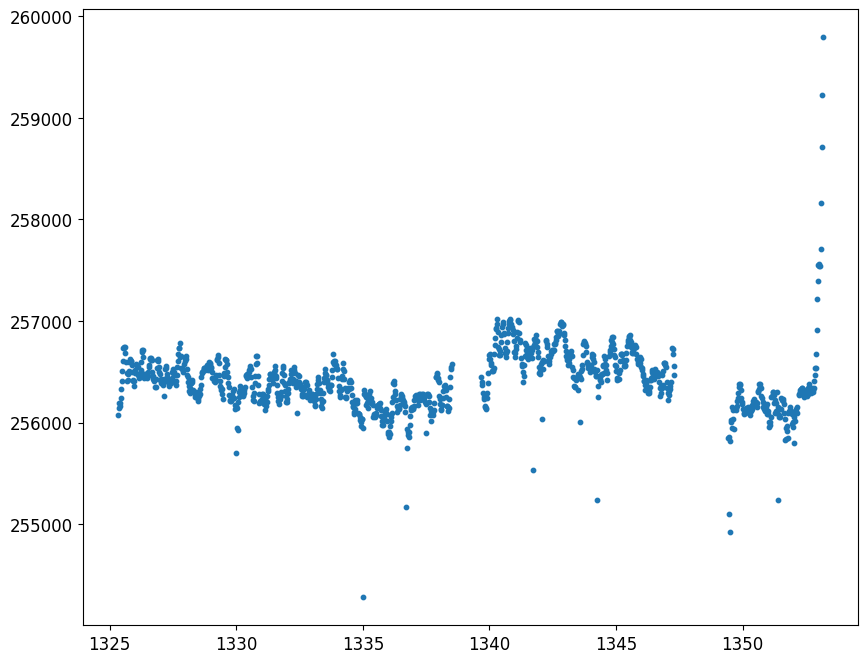

In [20]:
# target_lc.plot(label='Target + background');
plt.scatter(target_lc.time.value[bad_mask],target_lc.flux.value[bad_mask],s=10)
# plt.xlim(1345,1350)
plt.show()

In [21]:
target_lc = target_lc[bad_mask]

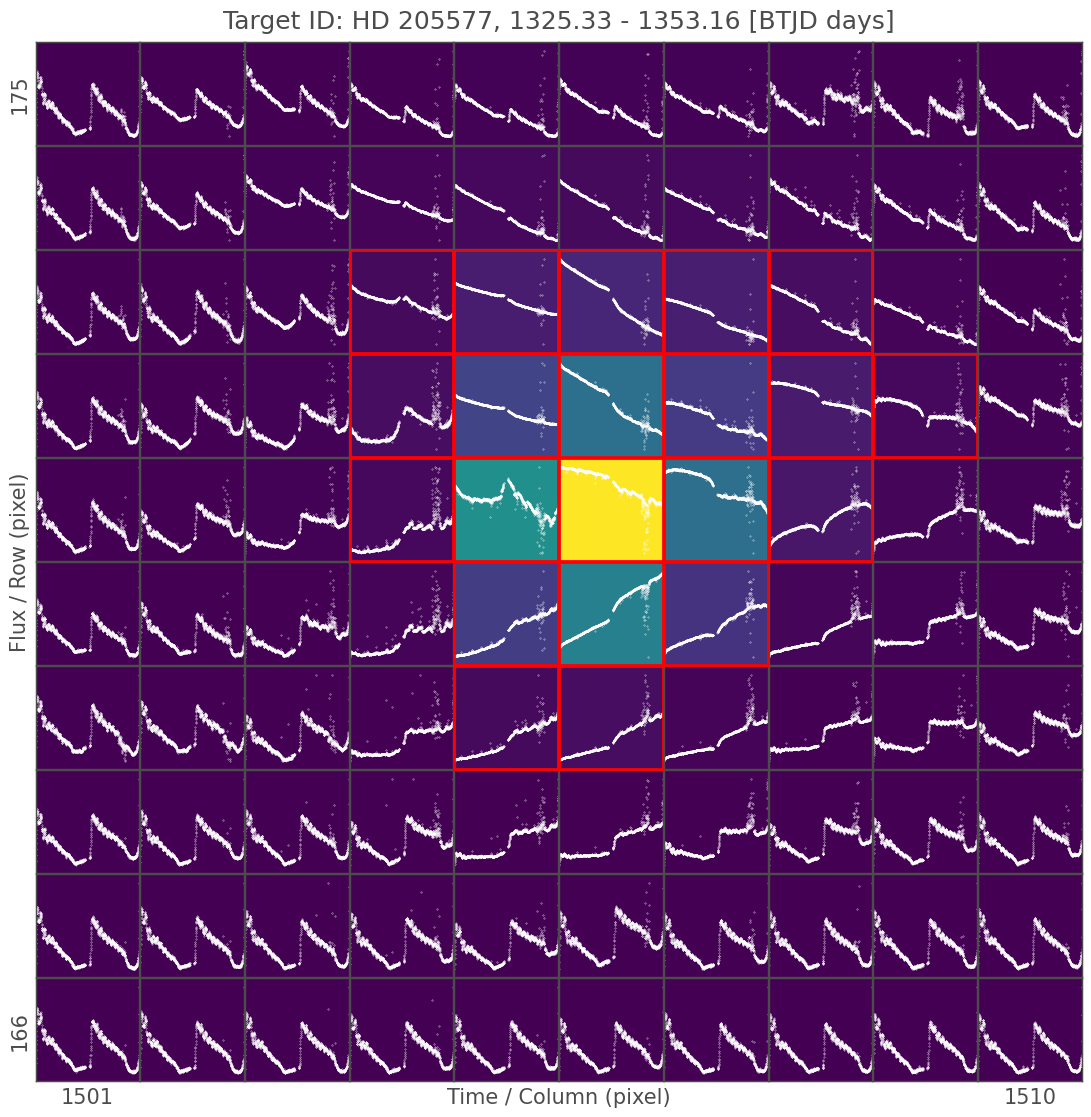

In [22]:
tpf.plot_pixels(aperture_mask=target_mask,show_flux=True);

In [23]:
# ## another possible way of doing the background
## it doesn't work very well
# regressors = tpf.flux[:, ~target_mask]
# regressors.shape

In [24]:
# plt.figure(figsize=(8,5))
# plt.plot(regressors[:, :30]);

In [25]:
# from lightkurve.correctors import DesignMatrix
# dm = DesignMatrix(regressors, name='regressors')

In [26]:
## kind of like the PDC algorithm
# dm = dm.pca(5)

In [27]:
# plt.figure(figsize=(8,5))
# plt.plot(tpf.time.value, dm.values + np.arange(5)*0.2, '.',markersize=5);

In [28]:
## needs a vertical offset component in the regression
# dm = dm.append_constant()

In [29]:
# from lightkurve.correctors import RegressionCorrector
# corrector = RegressionCorrector(target_lc)

In [30]:
# regression_lc = corrector.correct(dm)

In [31]:
# ax = target_lc.plot(label='Original light curve')
# regression_lc.plot(ax=ax, label='Corrected light curve');

In [32]:
# corrector.diagnose();


In [33]:
background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)

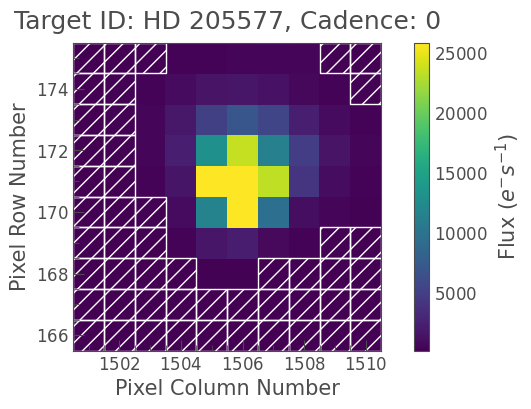

In [34]:
tpf.plot(aperture_mask=background_mask, mask_color='w');

In [35]:
n_background_pixels = background_mask.sum()
n_background_pixels

50

In [36]:
# tpf.interact_sky(aperture_mask=background_mask)

In [37]:
## this does an average!!
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
background_lc_per_pixel = background_lc_per_pixel[bad_mask]
background_estimate_lc = background_lc_per_pixel * n_target_pixels

In [38]:
## this does a median!
regressors = tpf.flux[:, ~target_mask]
# regressors = tpf.flux[:, ~background_mask]
median_bkg = np.median(regressors, axis=1)
median_bkg = median_bkg[bad_mask]

In [39]:
median_corrected_lc = target_lc - (median_bkg*n_target_pixels)

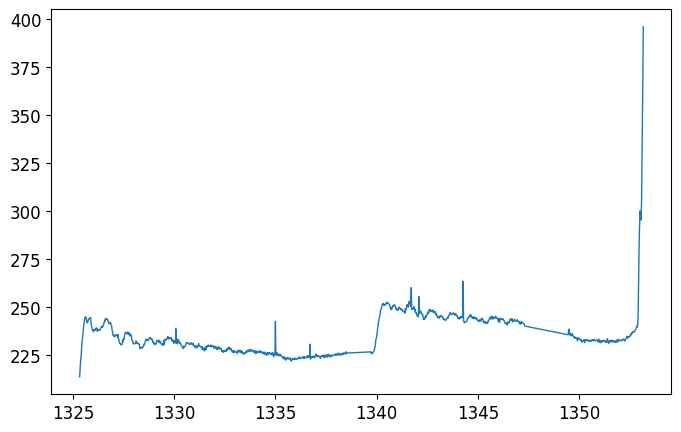

In [40]:
plt.figure(figsize=(8,5))
plt.plot(target_lc.time.value,median_bkg)
plt.show()

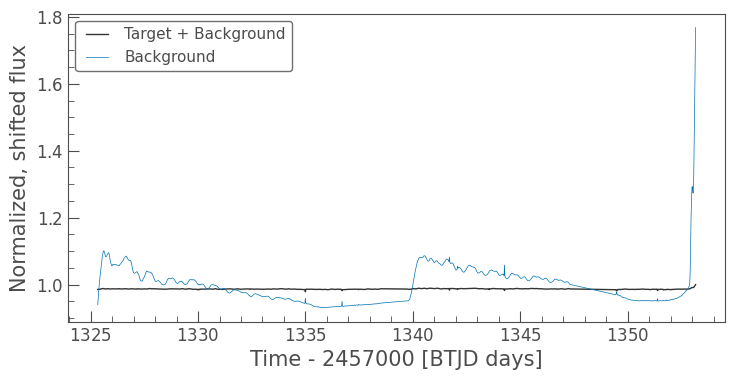

In [41]:
# common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc/np.max(target_lc.flux.value)).plot(normalize=False, label='Target + Background', lw=1);
background_estimate_lc.plot(ax=ax, normalize=True, label='Background',
                            ylabel='Normalized, shifted flux');
# (background_estimate_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
#                                                         ylabel='Normalized, shifted flux');

In [42]:
corrected_lc_s1 = target_lc - background_estimate_lc.flux

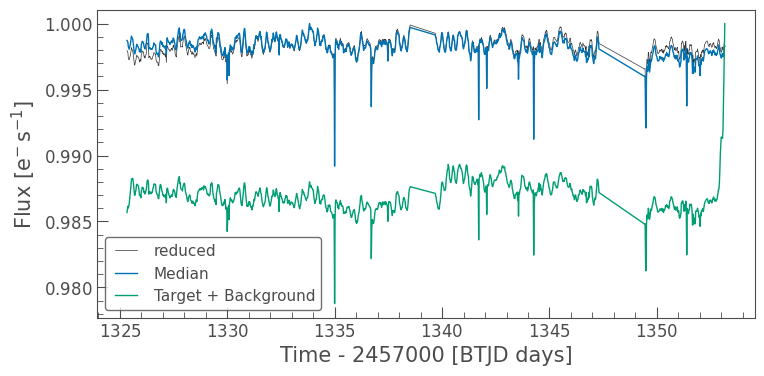

In [43]:
ax = (corrected_lc_s1/np.max(corrected_lc_s1.flux.value)).plot(label='reduced');
(median_corrected_lc/np.max(median_corrected_lc.flux.value)).plot(ax=ax, normalize=False, label='Median', lw=1);
(target_lc/np.max(target_lc.flux.value)).plot(ax=ax, normalize=False, label='Target + Background', lw=1);

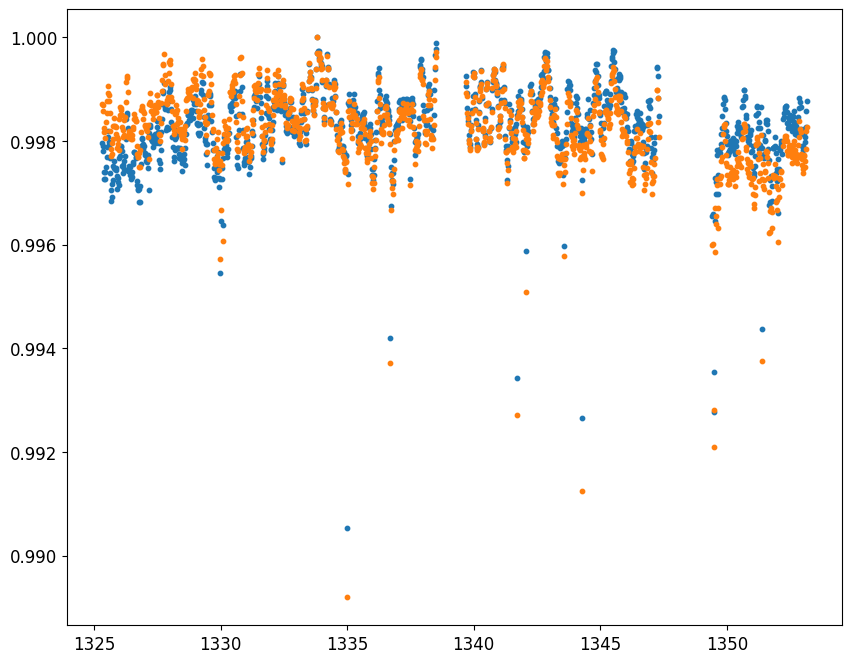

In [44]:
plt.scatter(corrected_lc_s1.time.value,
            corrected_lc_s1.flux.value/np.max(corrected_lc_s1.flux.value),s=10)
plt.scatter(median_corrected_lc.time.value,
            median_corrected_lc.flux.value/np.max(median_corrected_lc.flux.value),s=10)
plt.show()

In [45]:
# in theory this line should do nothing right now
# corrected_lc_s1_clipped = corrected_lc_s1.remove_nans().remove_outliers(sigma=5)
corrected_lc_s1_clipped = median_corrected_lc.remove_nans().remove_outliers(sigma=5)

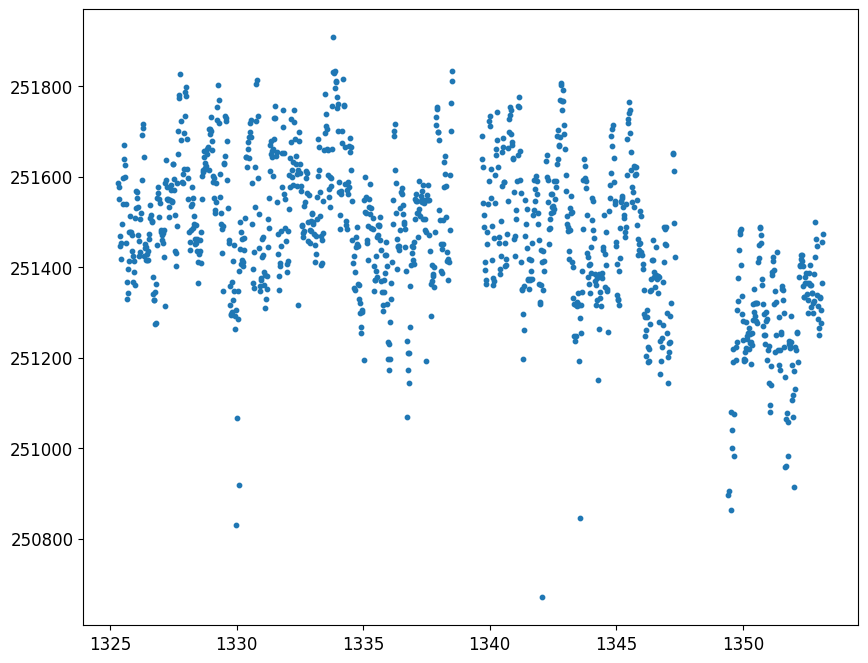

In [46]:
plt.scatter(corrected_lc_s1_clipped.time.value,corrected_lc_s1_clipped.flux.value,s=10)
# plt.axvline(corrected_lc_s1_clipped.time.value[1078],color='k')
# plt.axvline(corrected_lc_s1_clipped.time.value[990],color='k')
# plt.xlim(1345,1350)
plt.show()

In [47]:
width_days = 11.574/(5) # 1 uHz
time_s1,hpfiltered_s1 = apply_highpassfilter(np.asarray(corrected_lc_s1_clipped.time.value),
                                            np.asarray(corrected_lc_s1_clipped.flux.value),
                                            width_days=width_days)

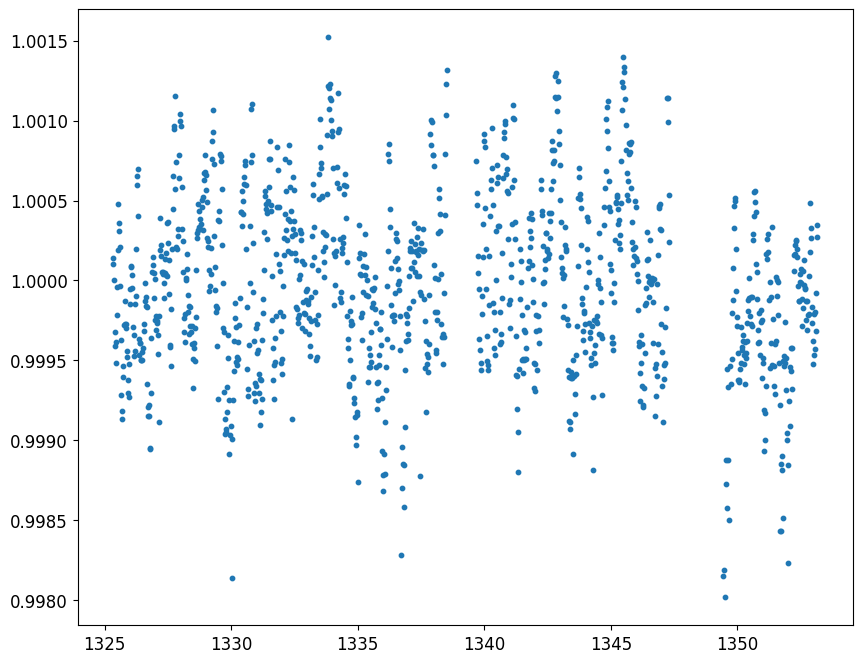

In [48]:
plt.scatter(time_s1,hpfiltered_s1,s=10)
plt.show()

# Sector 28

In [49]:
tpf = tesscut[1].download(cutout_size=10)

In [50]:
target_mask = tpf.create_threshold_mask(threshold=5, reference_pixel='center')
n_target_pixels = target_mask.sum()
n_target_pixels

22

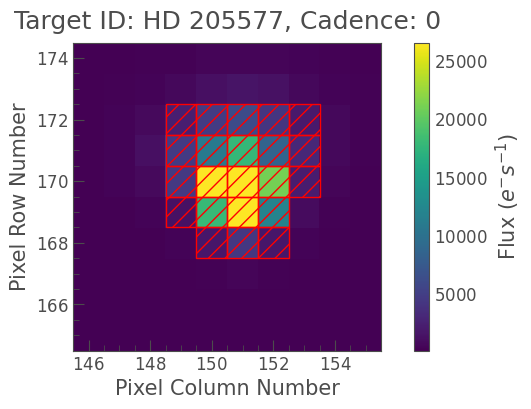

In [51]:
tpf.plot(aperture_mask=target_mask);

In [52]:
# tpf.interact_sky(aperture_mask=target_mask)

In [53]:
target_lc = tpf.to_lightcurve(aperture_mask=target_mask)


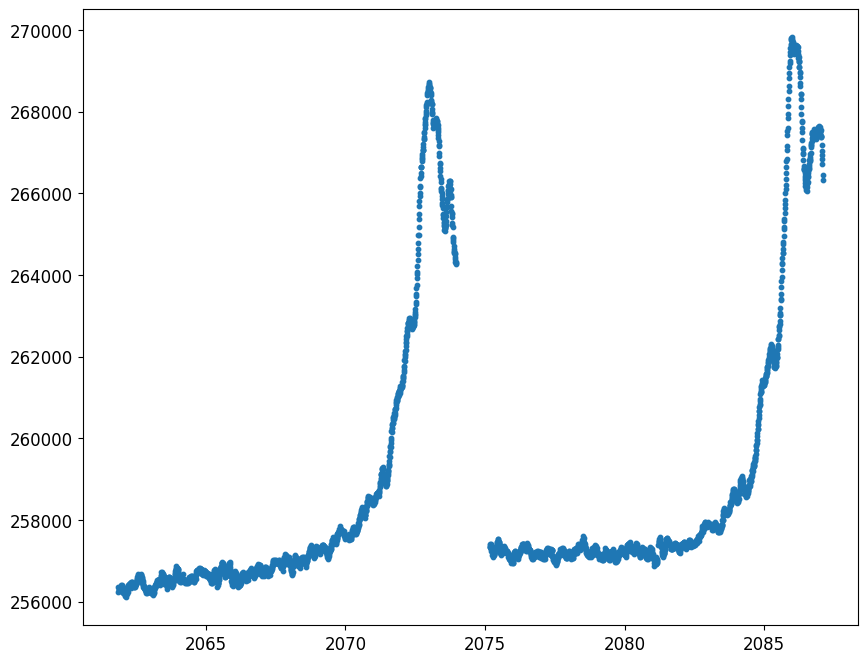

In [54]:
# target_lc.plot(label='Target + background');
plt.scatter(target_lc.time.value,target_lc.flux.value,s=10)
plt.show()

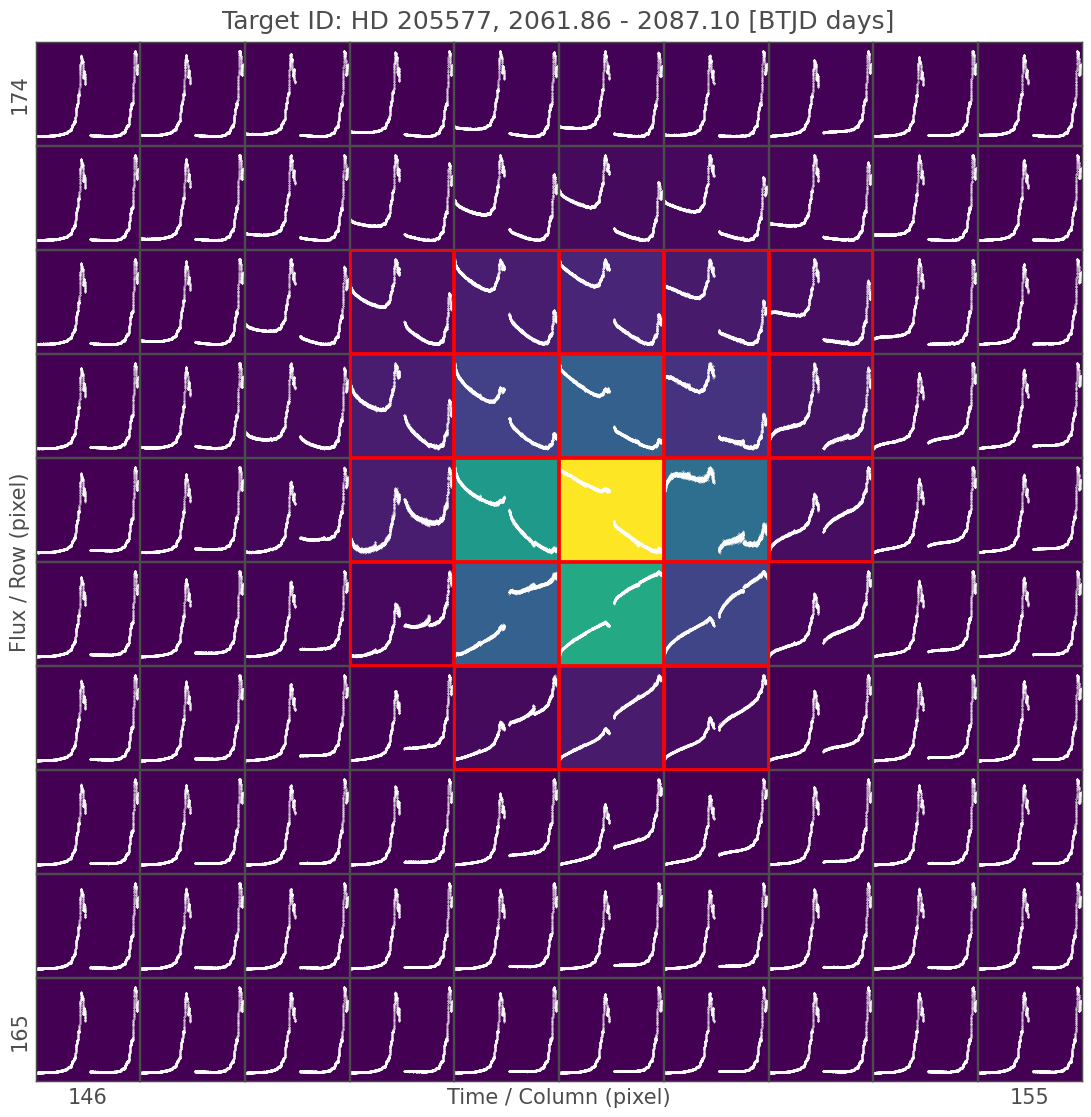

In [55]:
tpf.plot_pixels(aperture_mask=target_mask,show_flux=True);

In [56]:
background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)

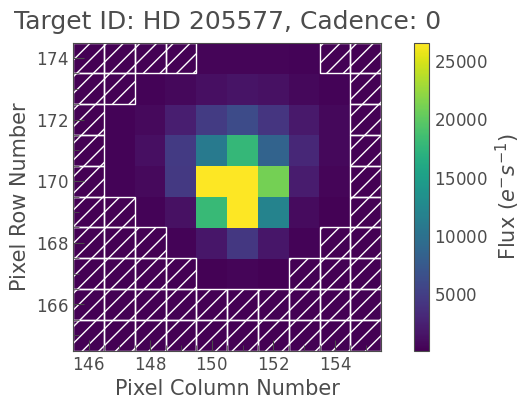

In [57]:
tpf.plot(aperture_mask=background_mask, mask_color='w');

In [58]:
n_background_pixels = background_mask.sum()
n_background_pixels

50

In [59]:
# tpf.interact_sky(aperture_mask=background_mask)

In [60]:
## average background
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
background_estimate_lc = background_lc_per_pixel * n_target_pixels

In [61]:
## this does a median!
regressors = tpf.flux[:, ~target_mask]
# regressors = tpf.flux[:, ~background_mask]
median_bkg = np.median(regressors, axis=1)
# median_bkg = median_bkg[bad_mask]

In [62]:
median_corrected_lc = target_lc - (median_bkg*n_target_pixels)

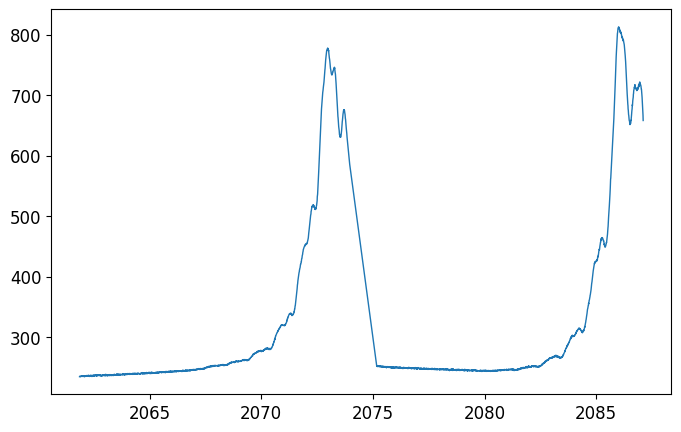

In [63]:
plt.figure(figsize=(8,5))
plt.plot(target_lc.time.value,median_bkg)
plt.show()

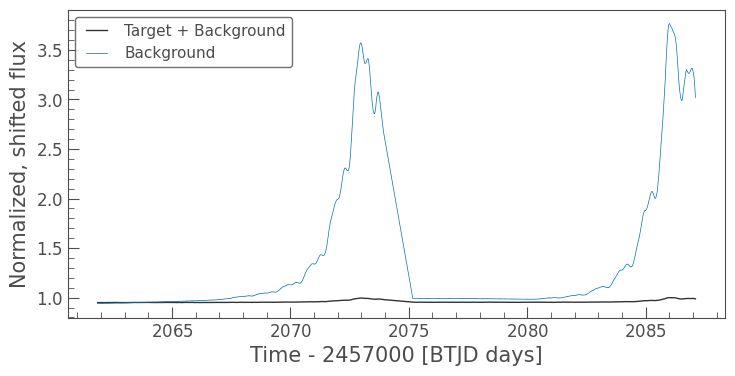

In [64]:
# common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc/np.max(target_lc.flux.value)).plot(normalize=False, label='Target + Background', lw=1);
background_estimate_lc.plot(ax=ax, normalize=True, label='Background',
                            ylabel='Normalized, shifted flux');
# (background_estimate_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background',
#                                                         ylabel='Normalized, shifted flux');

In [65]:
corrected_lc_s2 = target_lc - background_estimate_lc.flux

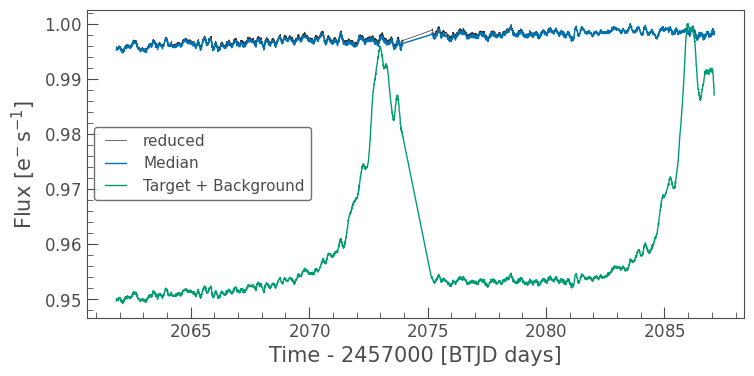

In [66]:
ax = (corrected_lc_s2/np.max(corrected_lc_s2.flux.value)).plot(label='reduced');
(median_corrected_lc/np.max(median_corrected_lc.flux.value)).plot(ax=ax, normalize=False, label='Median', lw=1);
(target_lc/np.max(target_lc.flux.value)).plot(ax=ax, normalize=False, label='Target + Background', lw=1);

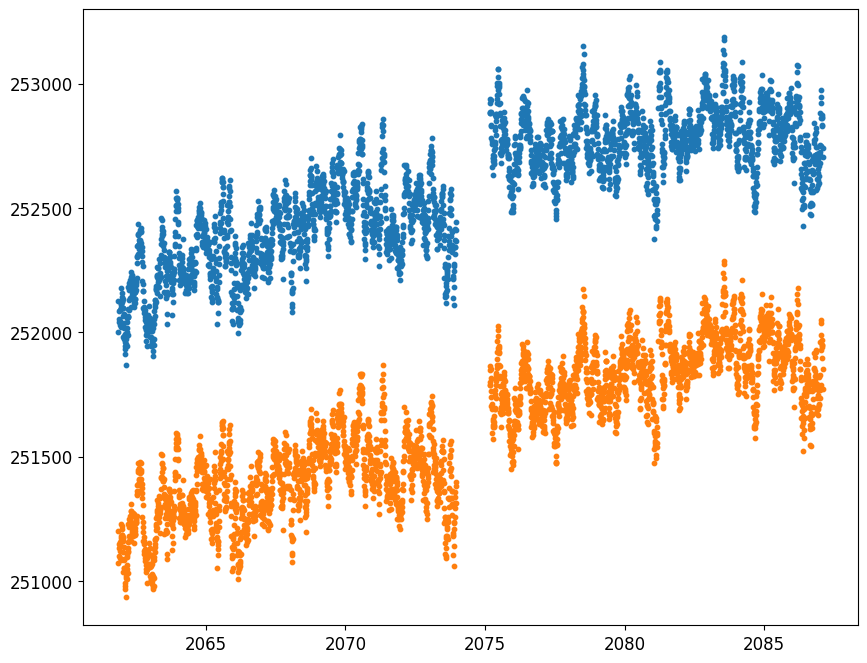

In [67]:
plt.scatter(corrected_lc_s2.time.value,corrected_lc_s2.flux.value,s=10)
plt.scatter(median_corrected_lc.time.value,median_corrected_lc.flux.value,s=10)
plt.show()

In [68]:
# corrected_lc_s2_clipped = corrected_lc_s2.remove_nans().remove_outliers(sigma=5)
corrected_lc_s2_clipped = median_corrected_lc.remove_nans().remove_outliers(sigma=5)

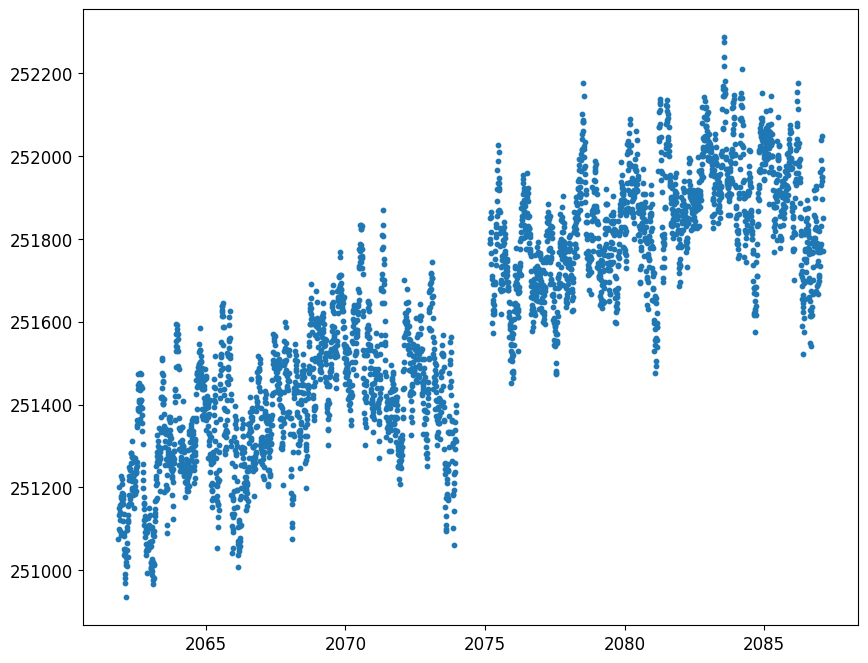

In [69]:
plt.scatter(corrected_lc_s2_clipped.time.value,corrected_lc_s2_clipped.flux.value,s=10)
plt.show()

In [70]:
width_days = 11.574/(5) # 1 uHz
time_s2,hpfiltered_s2 = apply_highpassfilter(np.asarray(corrected_lc_s2_clipped.time.value),
                                            np.asarray(corrected_lc_s2_clipped.flux.value),
                                            width_days=width_days)

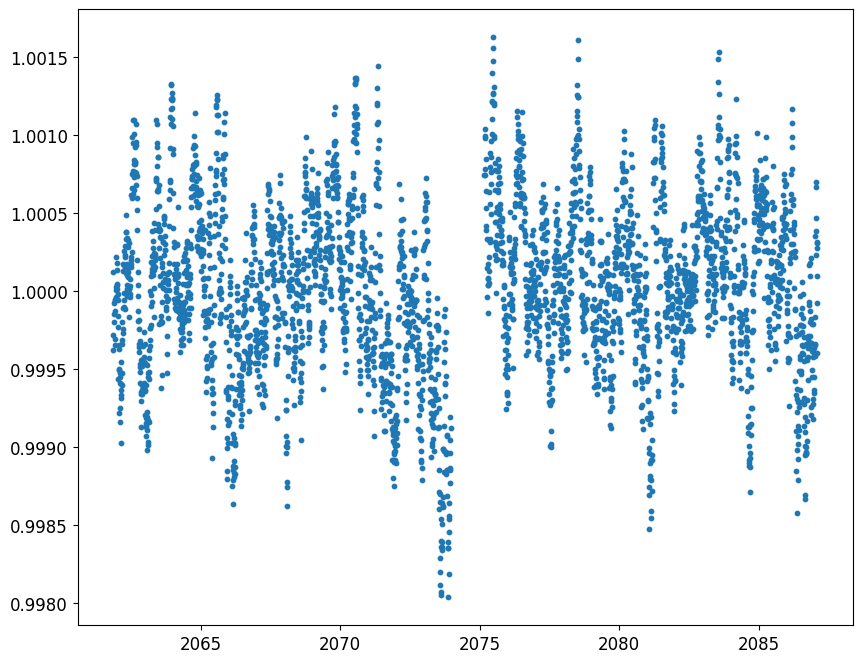

In [71]:
plt.scatter(time_s2,hpfiltered_s2,s=10)
plt.show()

# Combining these and looking at the power spectra

In [72]:
search_QLP = lk.search_lightcurve('HD 205577',author='QLP')
search_QLP

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,QLP,1800,441027157,0.0
1,TESS Sector 28,2020,QLP,600,441027157,0.0


In [73]:
lc_QLP = search_QLP.download_all().stitch().remove_nans().remove_outliers(sigma=4)

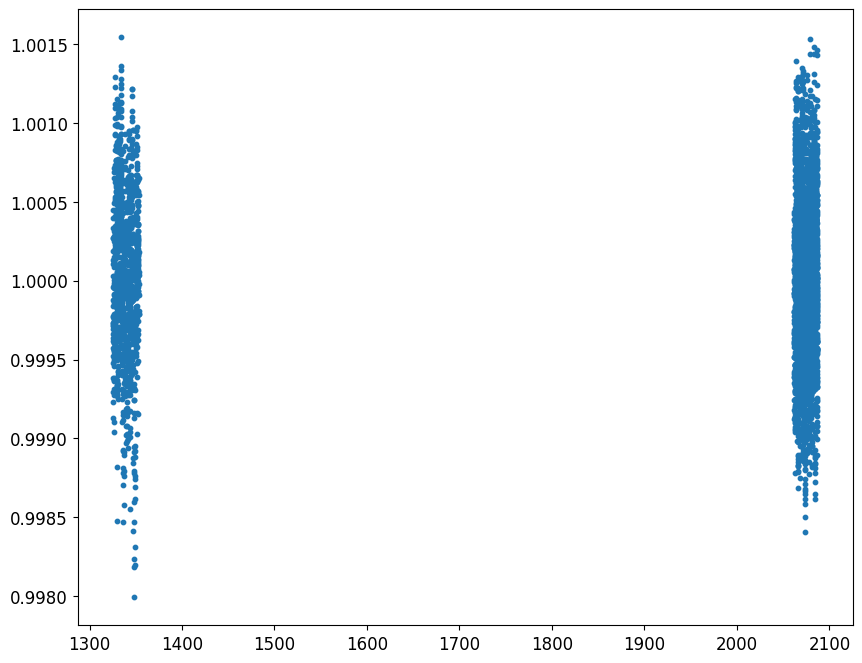

In [74]:
plt.scatter(lc_QLP.time.value,lc_QLP.flux.value,s=10)
plt.show()

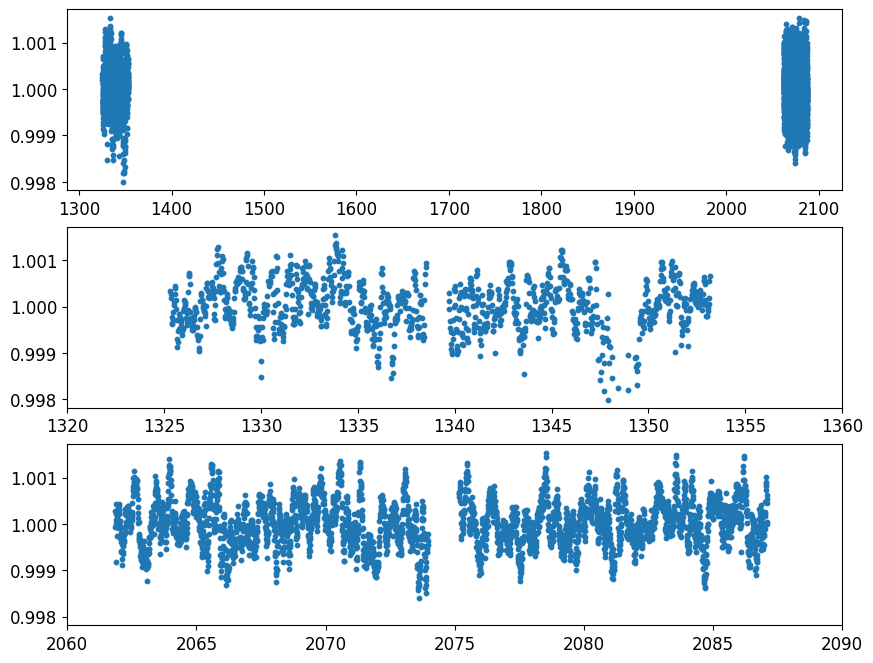

In [75]:
f,ax = plt.subplots(3,1)
ax[0].scatter(lc_QLP.time.value,lc_QLP.flux.value,s=10)
ax[1].scatter(lc_QLP.time.value,lc_QLP.flux.value,s=10)
ax[1].set_xlim(1320,1360)
ax[2].scatter(lc_QLP.time.value,lc_QLP.flux.value,s=10)
ax[2].set_xlim(2060,2090)
plt.show()

In [76]:
extracted_time = np.concatenate((time_s1,time_s2))
extracted_flux = np.concatenate((hpfiltered_s1,hpfiltered_s2))


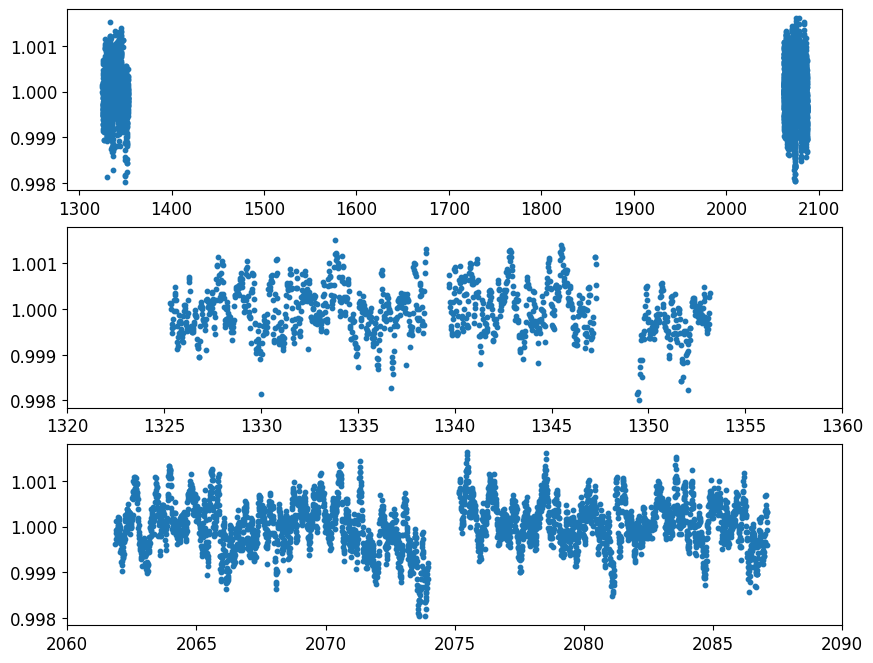

In [77]:
f,ax = plt.subplots(3,1)
ax[0].scatter(extracted_time,extracted_flux,s=10)
ax[1].scatter(extracted_time,extracted_flux,s=10)
ax[1].set_xlim(1320,1360)
ax[2].scatter(extracted_time,extracted_flux,s=10)
ax[2].set_xlim(2060,2090)
plt.show()

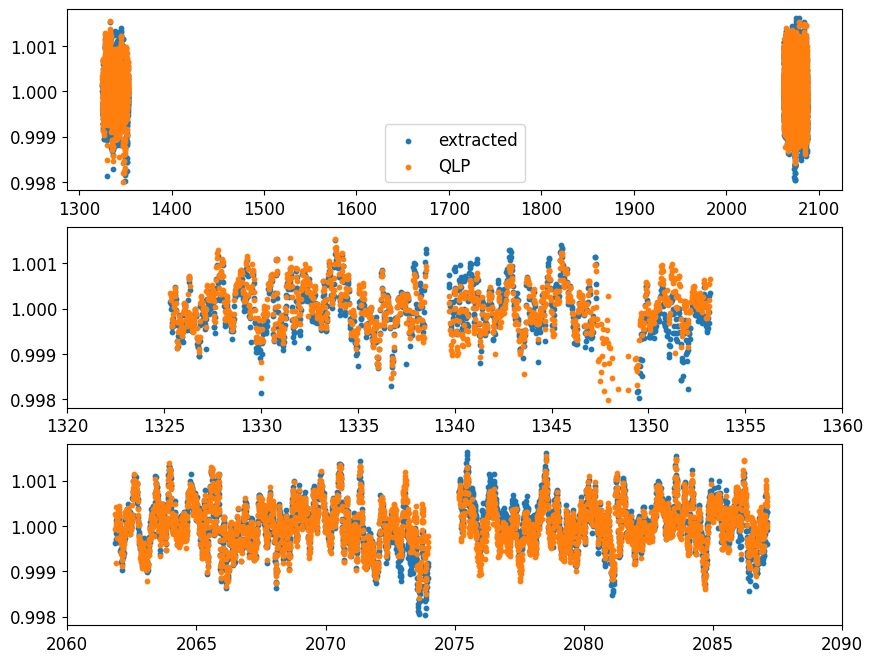

In [99]:
f,ax = plt.subplots(3,1)
ax[0].scatter(extracted_time,extracted_flux,s=10,label='extracted')
ax[0].scatter(lc_QLP.time.value,lc_QLP.flux.value,s=10,label='QLP')
ax[0].legend()

ax[1].scatter(extracted_time,extracted_flux,s=10)
ax[1].scatter(lc_QLP.time.value,lc_QLP.flux.value,s=10)
ax[1].set_xlim(1320,1360)

ax[2].scatter(extracted_time,extracted_flux,s=10)
ax[2].scatter(lc_QLP.time.value,lc_QLP.flux.value,s=10)
ax[2].set_xlim(2060,2090)

plt.savefig('/Users/ccra8514/Desktop/QLPvExtracted',dpi=300)
plt.show()

In [79]:
freq_QLP,amp_QLP = calc_lomb_scargle(lc_QLP.time.value,lc_QLP.flux.value)

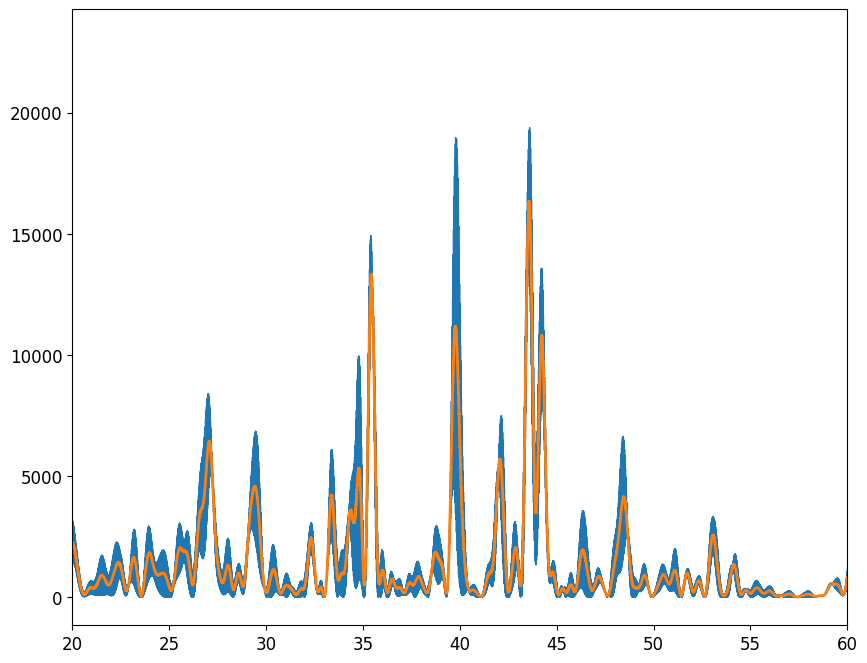

In [80]:
plt.plot(freq_QLP,amp_QLP**2)
freq_res_QLP = np.median(np.diff(freq_QLP))
smooth_QLP = convolve(amp_QLP**2,Box1DKernel((4*0.02)/freq_res_QLP))
plt.plot(freq_QLP,smooth_QLP,linewidth=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(5,280)
plt.xlim(20,60)
plt.show()

In [81]:
freq_extracted,amp_extracted = calc_lomb_scargle(extracted_time,extracted_flux)

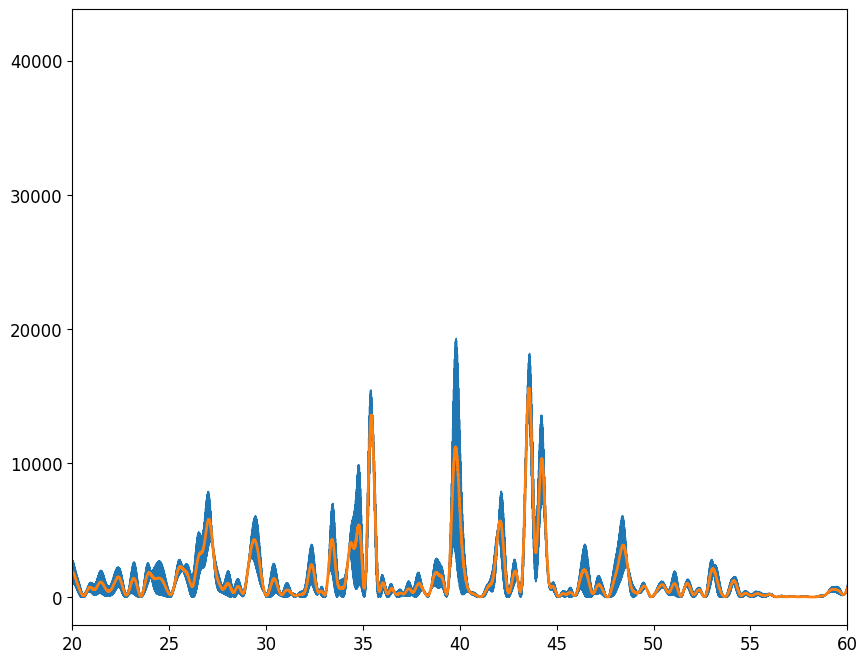

In [82]:
plt.plot(freq_extracted,amp_extracted**2)
freq_res_extracted = np.median(np.diff(freq_extracted))
smooth_extracted = convolve(amp_extracted**2,Box1DKernel((4*0.02)/freq_res_extracted))
plt.plot(freq_extracted,smooth_extracted,linewidth=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(5,280)
plt.xlim(20,60)
plt.show()

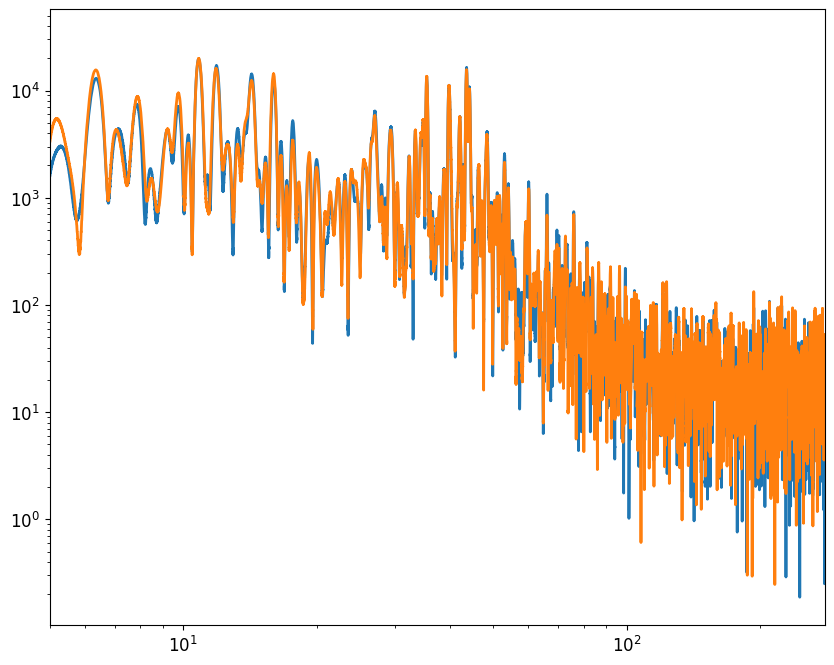

In [102]:
plt.plot(freq_QLP,smooth_QLP,linewidth=2,label='QLP')
plt.plot(freq_extracted,
         smooth_extracted,linewidth=2,label='extracted')

plt.xscale('log')
plt.yscale('log')
plt.xlim(5,280)

# plt.xlim(0,100)
# plt.ylim(-1000,20000)
# plt.legend()
plt.show()

In [84]:
def bg_slope_function(nu,numax):
    return (nu/numax)**(-2)

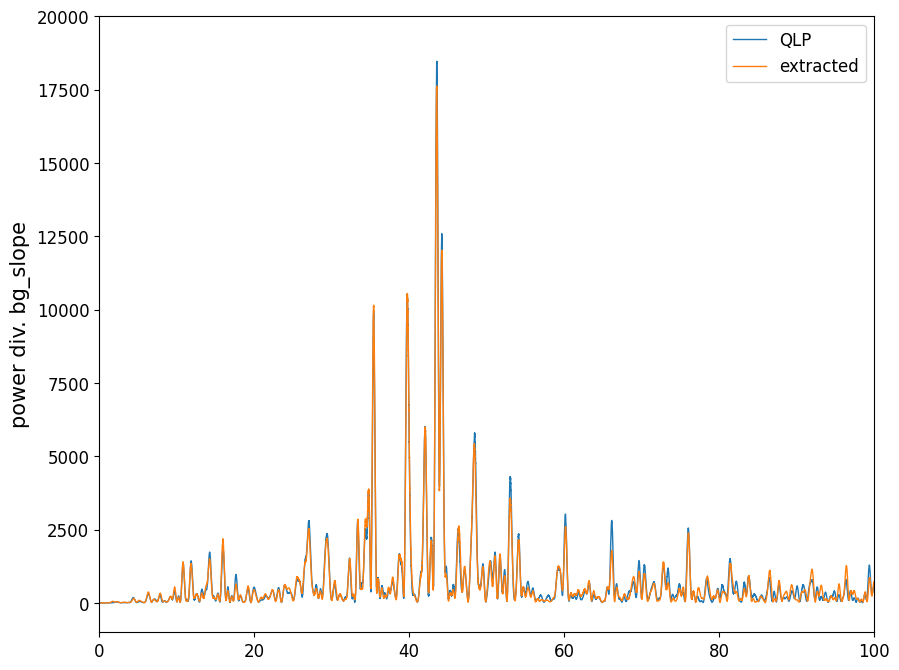

In [98]:
plt.plot(freq_QLP,smooth_QLP/bg_slope_function(freq_QLP,41),
         linewidth=1,label='QLP')
plt.plot(freq_extracted,smooth_extracted/bg_slope_function(freq_extracted,41),
         linewidth=1,label='extracted')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(5,280)

plt.xlim(0,100)
plt.ylim(-1000,20000)
plt.legend()
plt.ylabel('power div. bg_slope')
plt.savefig('/Users/ccra8514/Desktop/powerspec_compare',dpi=300)
plt.show()

# Now for the echelles

In [86]:
def yl_echelle(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0):
    '''
    Make an echelle plot used in asteroseismology.
    
    Input parameters
    ----
    x: 1d array-like, freq
    y: 1d array-like, power spectrum
    period: float, length of each vertical stack (Dnu in a frequency echelle, DPi in a period echelle)
    fmin: float, minimum frequency to be plotted
    fmax: float, maximum frequency to be plotted
    echelletype: str, `single` or `replicated`
    offset: float, an amount by which the diagram is shifted horizontally
    
    Return
    ----
    z: a 2d numpy.array, folded power spectrum
    extent: a list, edges (left, right, bottom, top) 
    
    Users can create an echelle diagram with the following command:
    ----
    
    import matplotlib.pyplot as plt
    z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
    plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
    '''
    
    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin = fmin - offset
    fmax = fmax - offset
    x = x - offset

    fmin = 0.0 if fmin<0. else fmin - (fmin % period)

    # define plotting elements
    resolution = np.median(np.diff(x))
    # number of vertical stacks
    n_stack = int((fmax-fmin)/period) 
    # number of point per stack
    n_element = int(period/resolution) 

    fstart = fmin - (fmin % period)
    
    z = np.zeros([n_stack, n_element])
    base = np.linspace(0, period, n_element) if echelletype=='single' else np.linspace(0, 2*period, n_element)
    for istack in range(n_stack):
        z[-istack-1,:] = np.interp(fmin+istack*period+base, x, y)
    
    extent = (0, period, fstart, fstart+n_stack*period) if echelletype=='single' else (0, 2*period, fstart, fstart+n_stack*period)
        
    return z, extent

In [87]:
# fig,ax = plt.subplots(figsize=(8,8))
# z, ext = yl_echelle(freq, power, dnu, fmin=fmin, fmax=fmax, echelletype="replicated")
# z = np.sqrt(z) #sqrt scaling
# ax.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='Greys')
# ax.axvline(dnu,color='k',linestyle='--',alpha=0.5)
# ax.set_xlabel(r"Frequency mod "+str("{0:.3f}").format(dnu) + " ($\mu$Hz)",size=20)
# #     ax.set_ylabel('Frequency ($\mu$Hz)',size=20)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

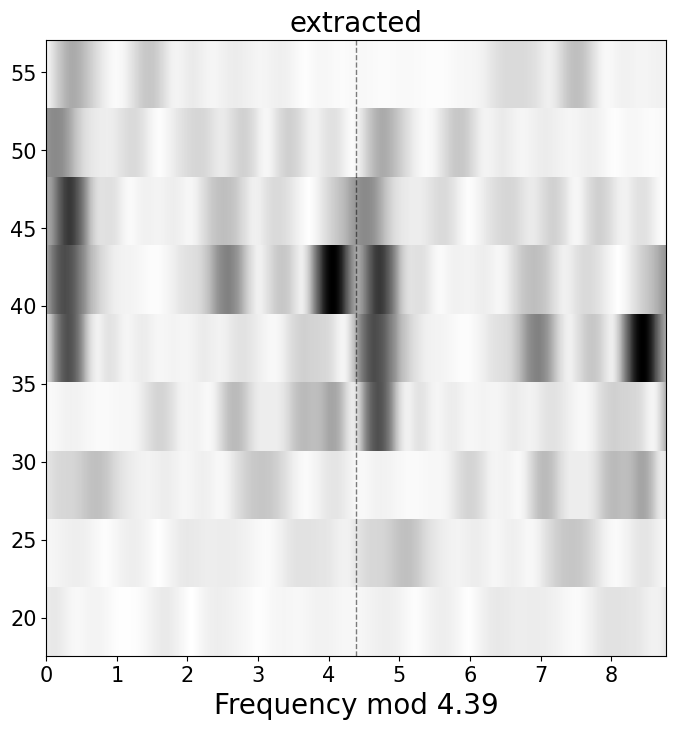

In [97]:
fig,ax = plt.subplots(figsize=(8,8))
z, ext = yl_echelle(freq_extracted,smooth_extracted/bg_slope_function(freq_extracted,41),
                    4.39, fmin=20, fmax=60, echelletype="replicated")
z = np.sqrt(z) #sqrt scaling
ax.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='Greys')
ax.axvline(4.39,color='k',linestyle='--',alpha=0.5)
ax.set_xlabel(r"Frequency mod 4.39",size=20)
#     ax.set_ylabel('Frequency ($\mu$Hz)',size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('extracted',fontsize=20)
plt.savefig('/Users/ccra8514/Desktop/extracted_echelle',dpi=300)
plt.show()

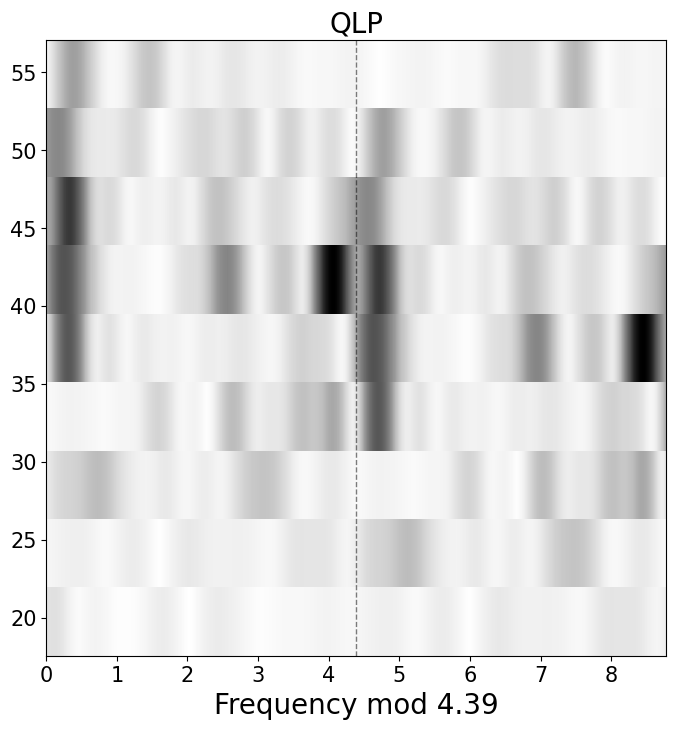

In [89]:
fig,ax = plt.subplots(figsize=(8,8))
z, ext = yl_echelle(freq_QLP,smooth_QLP/bg_slope_function(freq_QLP,41),
                    4.39, fmin=20, fmax=60, echelletype="replicated")
z = np.sqrt(z) #sqrt scaling
ax.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='Greys')
ax.axvline(4.39,color='k',linestyle='--',alpha=0.5)
ax.set_xlabel(r"Frequency mod 4.39",size=20)
#     ax.set_ylabel('Frequency ($\mu$Hz)',size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('QLP',fontsize=20)
# plt.savefig('/Users/courtneycrawford/Desktop/QLP_echelle',dpi=300)
plt.show()

# Check each sector?

In [90]:
freq_extracted_s1,amp_extracted_s1 = calc_lomb_scargle(time_s1,hpfiltered_s1)
freq_extracted_s2,amp_extracted_s2 = calc_lomb_scargle(time_s2,hpfiltered_s2)

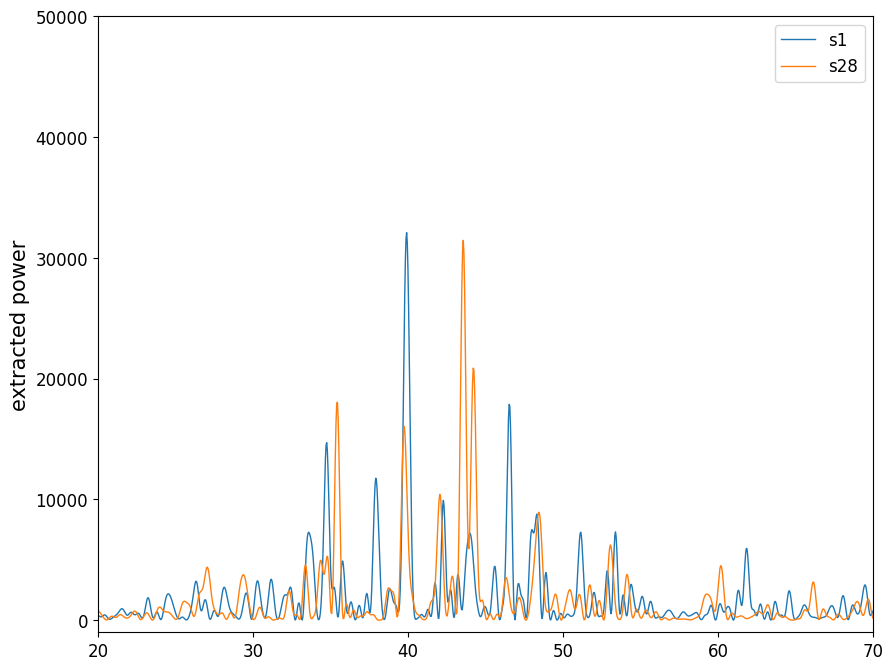

In [91]:
plt.plot(freq_extracted_s1,amp_extracted_s1**2/bg_slope_function(freq_extracted_s1,41),label='s1')
plt.plot(freq_extracted_s2,amp_extracted_s2**2/bg_slope_function(freq_extracted_s2,41),label='s28')
# freq_res_extracted_s1 = np.median(np.diff(freq_extracted_s1))
# smooth_extracted_s1 = convolve(amp_extracted_s1**2,Box1DKernel((4*0.02)/freq_res_extracted_s1))
# plt.plot(freq_extracted_s1,smooth_extracted_s1,linewidth=2)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(5,280)
plt.xlim(20,70)
plt.ylim(-1000,50000)
plt.legend()
plt.ylabel('extracted power')
# plt.savefig('/Users/courtneycrawford/Desktop/powerspec_sectors',dpi=300)
plt.show()

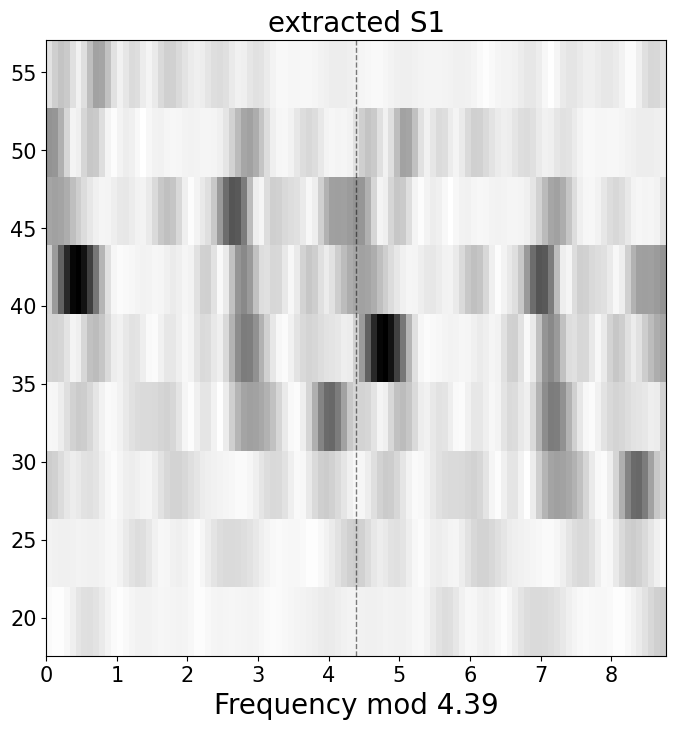

In [92]:
fig,ax = plt.subplots(figsize=(8,8))
z, ext = yl_echelle(freq_extracted_s1,
                    amp_extracted_s1**2/bg_slope_function(freq_extracted_s1,41),
                    4.39, fmin=20, fmax=60, echelletype="replicated")
z = np.sqrt(z) #sqrt scaling
ax.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='Greys')
ax.axvline(4.39,color='k',linestyle='--',alpha=0.5)
ax.set_xlabel(r"Frequency mod 4.39",size=20)
#     ax.set_ylabel('Frequency ($\mu$Hz)',size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('extracted S1',fontsize=20)
# plt.savefig('/Users/courtneycrawford/Desktop/extracted_echelle_s1',dpi=300)
plt.show()

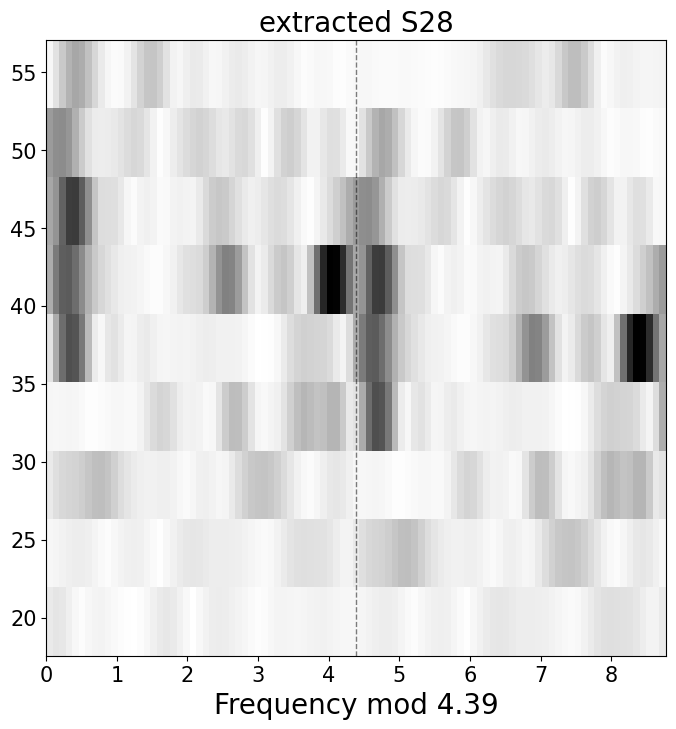

In [93]:
fig,ax = plt.subplots(figsize=(8,8))
z, ext = yl_echelle(freq_extracted_s2,
                    amp_extracted_s2**2/bg_slope_function(freq_extracted_s2,41),
                    4.39, fmin=20, fmax=60, echelletype="replicated")
z = np.sqrt(z) #sqrt scaling
ax.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='Greys')
ax.axvline(4.39,color='k',linestyle='--',alpha=0.5)
ax.set_xlabel(r"Frequency mod 4.39",size=20)
#     ax.set_ylabel('Frequency ($\mu$Hz)',size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('extracted S28',fontsize=20)
# plt.savefig('/Users/courtneycrawford/Desktop/extracted_echelle_s2',dpi=300)
plt.show()

# save the extracted light curve

In [94]:
extracted_data = np.c_[(extracted_time,extracted_flux)]
extracted_frame = pd.DataFrame(extracted_data,columns=['time','flux'])
extracted_frame

,time,flux
0,1325.328888,1.000139
1,1325.349722,1.000106
2,1325.370556,1.000001
3,1325.391390,0.999677
4,1325.412224,0.999589
...,...,...
4598,2087.071594,1.000093
4599,2087.078538,1.000311
4600,2087.085483,1.000308
4601,2087.092427,0.999600


In [96]:
# extracted_frame.to_csv('/Users/ccra8514/Desktop/HD208877_extractedLC.csv',index=False)